In [1]:
%matplotlib inline
import sys
import os
os.environ['THEANO_FLAGS'] = 'compiledir_format=ipynb_cpu'
sys.path.append('..')
from tools.brushstroke.common import load_model
from tools.brushstroke.fractal import gen
from IPython.display import Image
import numpy as np

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
model_a, data, layers = load_model("../training/fractal/b/model.pkl")
model_b, data, layers = load_model("../training/fractal/b2/model.pkl")
model_c, data, layers = load_model("../training/fractal/a6/model.pkl")
model_d, data, layers = load_model("../training/fractal/c/model.pkl")
model_e, data, layers = load_model("../training/fractal/d/model.pkl")

(None, 1, 8, 8)
Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 64))
loaded
(128, 128, (128000, 64))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 8, 8)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 16, 16)
Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 256))
loaded
(128, 128, (128000, 256))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 16, 16)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 32, 32)
Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 32, 32)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 64, 64)
Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 64, 64)
Compiling the model...


INFO:tasks:Compiling the model...


(None, 1, 128, 128)
Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 128, 128)
Compiling the model...


INFO:tasks:Compiling the model...


In [71]:
a = [
 
    {'model': model_a, 
     'on': 'crops', 
     'padlen': 1,   
     'nb_iter':  1,   
     'thresh': 'moving', 
     'when': 'always', 
     'whitepx_ratio': 0.4}
]
b = [
    {'model': model_b, 
     'on': 'crops', 
     'padlen': 3,  
     'nb_iter':  5,   
     'thresh': 'moving', 
     'when': 0.01, 
     'whitepx_ratio': 0.4},
]

c =[
     {'model': model_c, 
     'on': 'crops', 
     'padlen': 3,   
     'nb_iter':  10,   
     'inner_padlen': 3,
     'thresh': 'moving', 
     'when': 'always', 
     'whitepx_ratio': 0.1},
]

d = [
    {'model': model_d, 
     'on': 'crops', 
     'padlen': 10,   
     'nb_iter':  10,   
     'inner_padlen': 1,
     'thresh': 'moving',
     'when': 0.1,
     'whitepx_ratio': 0.1}]
neuralnets = a+d

951


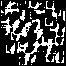

In [72]:
seed = np.random.randint(1, 1000)
np.random.seed(seed)
print(seed)
img, snap = gen(neuralnets, nb_iter=1000, w=2**6, h=2**6, init='random', out='manual.png')
Image('manual.png', width=200, height=200)